# Code for Section 2.6 Naive CVaR and Variance Optimization Backtesting

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import fortitudo.tech as ft
import matplotlib.pyplot as plt

# Download and preprocess data

In [2]:
tickers = [
    'XLB', 'XLE', 'XLF', 'XLI', 'XLK',
    'XLP', 'XLU', 'XLV', 'XLY', '^GSPC']
data = yf.download(tickers, start='1998-12-22', end='2024-10-12')['Close']

names_dict = {
    'XLB': 'Materials', 'XLE': 'Energy', 'XLF': 'Financial', 'XLI': 'Industrial',
    'XLK': 'Technology', 'XLP': 'Consumer Staples', 'XLU': 'Utilities',
    'XLV': 'Health Care', 'XLY': 'Consumer Discretionary', '^GSPC': 'S&P 500'}
data = data.rename(columns=names_dict)

T = len(data)
print(f'The number of daily observations is {T}.')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed

The number of daily observations is 6493.


# Compute equity returns

In [3]:
H = 63
equity_returns = (data.values[H:, :] - data.values[0:-H, :]) / data.iloc[0:-H, :]
equity_returns_df = pd.DataFrame(100 * equity_returns, columns=data.columns)
equity_stats = ft.simulation_moments(equity_returns_df)
cvars = ft.portfolio_cvar(
    np.eye(len(equity_returns_df.columns)), equity_returns_df, alpha=0.9)
equity_stats['90%-CVaR'] = cvars[0, :]
display(np.round(equity_stats, 2))

,Mean,Volatility,Skewness,Kurtosis,90%-CVaR
Ticker,,,,,
Materials,2.50,9.92,-0.48,5.99,18.89
Energy,2.79,12.38,-0.22,5.35,22.66
Financial,1.98,11.45,-0.07,9.35,22.41
Industrial,2.54,9.27,-0.62,5.77,18.62
Technology,2.73,11.01,-0.62,4.24,22.76
Consumer Staples,1.85,5.81,-0.59,4.49,11.61
Utilities,2.12,7.61,-0.62,4.80,15.10
Health Care,2.31,6.79,-0.58,4.22,13.15
Consumer Discretionary,2.65,9.45,-0.29,5.08,18.20


# Backtest

In [4]:
out_of_sample_years = 15
out_of_sample_obs = out_of_sample_years * 252
out_of_sample_quarters = out_of_sample_years * 4

# Set long-only constraints and preallocate space for results
I = len(tickers)
G = -np.eye(I)
h = np.zeros(I)

cvar_results = np.full((I, out_of_sample_quarters), np.nan)
variance_results = np.full((I, out_of_sample_quarters), np.nan)
for q in np.arange(out_of_sample_quarters):
    in_sample_returns = equity_returns[:-out_of_sample_obs + q * H]
    cvar_opt = ft.MeanCVaR(in_sample_returns.values, G=G, h=h, alpha=0.9)
    means = np.mean(in_sample_returns, axis=0)
    cov_matrix = ft.covariance_matrix(in_sample_returns).values
    mv_opt = ft.MeanVariance(means, cov_matrix, G=G, h=h)

    cvar_results[:, q] = cvar_opt.efficient_portfolio()[:, 0]
    variance_results[:, q] = mv_opt.efficient_portfolio()[:, 0]

# Performance

In [5]:
out_of_sample_data = 100 * data.iloc[-out_of_sample_obs:, :] / data.iloc[-out_of_sample_obs, :].values
out_of_sample_data = out_of_sample_data.values

performance_cvar = np.full(out_of_sample_obs, np.nan)
performance_cvar[0] = 100
performance_variance = np.full(out_of_sample_obs, np.nan)
performance_variance[0] = 100

for q in np.arange(out_of_sample_quarters):
    holding_cvar = performance_cvar[q * H] * cvar_results[:, q] / out_of_sample_data[q * H, :]
    performance_cvar[1 + q * H:(q + 1) * H + 1] = out_of_sample_data[1 + q * H:(q + 1) * H + 1, :] @ holding_cvar

    holding_variance = performance_variance[q * H] * variance_results[:, q] / out_of_sample_data[q * H, :]
    performance_variance[1 + q * H:(q + 1) * H + 1] = out_of_sample_data[1 + q * H:(q + 1) * H + 1, :] @ holding_variance

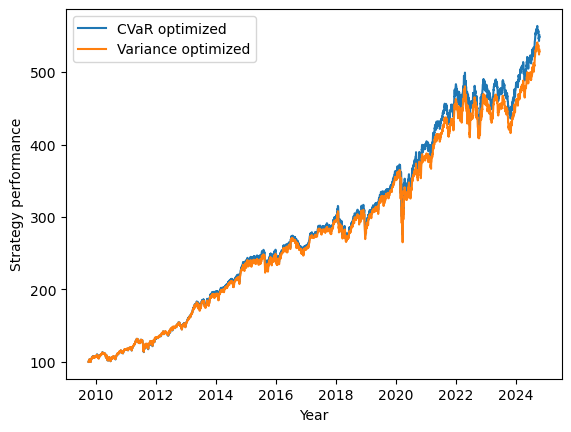

In [6]:
plt.plot(data.iloc[-out_of_sample_obs:].index, performance_cvar)
plt.plot(data.iloc[-out_of_sample_obs:].index, performance_variance)
plt.legend(['CVaR optimized', 'Variance optimized'])
plt.xlabel('Year')
plt.ylabel('Strategy performance')
plt.show()

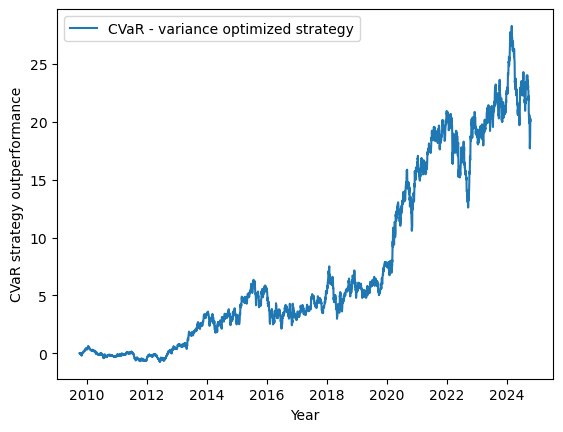

In [7]:
plt.plot(data.iloc[-out_of_sample_obs:].index, performance_cvar - performance_variance)
plt.legend(['CVaR - variance optimized strategy'])
plt.xlabel('Year')
plt.ylabel('CVaR strategy outperformance')
plt.show()

In [8]:
# pcrm-book - Next generation investment analysis.
# Copyright (C) 2025 Anton Vorobets.

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.